## Creating a Sankey diagram to show the amount of trade between major coffee bean exporters and importers (US, EU)

Acording to data from the International Coffee Organization, in the 2021 coffee year was approximately 9.109 billion kg. The percentages of world coffee bean imports are as follows:[1]

* European Union: 33.8%
* United States: 27.9%

In this Jupyter notebook, we wanted to show how much coffee beans the United States and the EU, which are major coffee bean importers, are getting from the major coffee bean producing countries using a Sankey diagram. 

Data source - FAO(Food and Arriculture Organization of the United Nations
https://www.fao.org/faostat/en/#data)

[1] International Coffee Organization. (n.d.). Monthly Coffee Trade Statistics - Imports. Retrieved from https://www.ico.org/prices/m4-imports.pdf

In [2]:
import sys
import json
import csv
import yaml

import pandas as pd
import numpy as np

import matplotlib as mpl
from cycler import cycler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from owlready2 import *

In [3]:
import psycopg2
from sqlalchemy import create_engine, text as sql_text

### Getting data from FAO and preprocessing

In [4]:
# Data on coffee bean exports to the EU from the top 20 coffee bean producing countries.
df_EU = pd.read_csv('11to21_top20_EU.csv') 

In [5]:
# Data on coffee bean exports to the USA from the top 20 coffee bean producing countries.
df_US = pd.read_csv('11to21_top20_US.csv')

In [6]:
# Use the most recent, 2021 data
filtered_df_US = df_US[(df_US['Item'] == 'Coffee, green') & (df_US['Item Code (CPC)'] == 1610.0) & (df_US['Year'] == 2021) ]

In [7]:
filtered_df_US = filtered_df_US.loc[:, ['Reporter Country Code (M49)', 'Reporter Countries', 
                                  'Partner Country Code (M49)', 'Partner Countries', 
                                  'Item Code (CPC)', 'Item', 'Year Code', 'Year', 
                                  'Unit', 'Value']]
filtered_df_US['Countries Group'] = ['USA'] * len(filtered_df_US)
selected_df_US = filtered_df_US.loc[:,['Reporter Country Code (M49)', 'Reporter Countries', 'Value', 'Countries Group']]

In [8]:
print(selected_df_US)

     Reporter Country Code (M49)           Reporter Countries      Value  \
38                            76                       Brazil  445607.72   
72                           156              China, mainland    3851.99   
116                          170                     Colombia  284124.44   
160                          188                   Costa Rica   28993.35   
205                          218                      Ecuador     215.35   
249                          222                  El Salvador   15601.23   
280                          231                     Ethiopia   30934.90   
324                          320                    Guatemala   90250.62   
360                          340                     Honduras  110352.68   
414                          356                        India    2906.95   
449                          360                    Indonesia   57694.03   
479                          404                        Kenya    5464.37   
518         

In [9]:
filtered_df_US.to_csv('CoffeeBean_2021_to_US.csv', index=False)
selected_df_US.to_csv('CoffeeBean_2021_to_US_4_Shanky.csv', index=False)

In [10]:
filtered_df_EU = df_EU[(df_EU['Item'] == 'Coffee, green') & (df_EU['Item Code (CPC)'] == 1610.0) & (df_EU['Year'] == 2021) ]

In [11]:
grouped_df_EU = filtered_df_EU.groupby(['Reporter Country Code (M49)', 'Reporter Countries', 'Partner Country Code (M49)', 'Partner Countries'])['Value'].sum().reset_index()
grouped_df_EU['Countries Group'] = ['EU'] * len(grouped_df_EU)

In [12]:
selected_df_EU = grouped_df_EU.groupby(['Reporter Country Code (M49)', 'Reporter Countries', 'Countries Group'])['Value'].sum().reset_index()

In [13]:
print(selected_df_EU)

    Reporter Country Code (M49)           Reporter Countries Countries Group  \
0                            76                       Brazil              EU   
1                           156              China, mainland              EU   
2                           170                     Colombia              EU   
3                           188                   Costa Rica              EU   
4                           218                      Ecuador              EU   
5                           222                  El Salvador              EU   
6                           231                     Ethiopia              EU   
7                           320                    Guatemala              EU   
8                           340                     Honduras              EU   
9                           356                        India              EU   
10                          360                    Indonesia              EU   
11                          404         

In [14]:
grouped_df_EU.to_csv('CoffeeBean_2021_to_EU_noGroup.csv', index=False)
selected_df_EU.to_csv('CoffeeBean_2021_to_EU_4_Shanky.csv', index=False)

In [15]:
# EU Merge EU and USA data to create a Sankey diagram
union_df = pd.concat([selected_df_US, selected_df_EU])

# Concatenated data frame(USA + EU)
sorted_union_df = union_df.sort_values(by=['Reporter Country Code (M49)', 'Countries Group'], ascending=True)

In [16]:
print(sorted_union_df)

     Reporter Country Code (M49)           Reporter Countries       Value  \
0                             76                       Brazil  1049988.02   
38                            76                       Brazil   445607.72   
1                            156              China, mainland    13537.39   
72                           156              China, mainland     3851.99   
2                            170                     Colombia   176480.77   
116                          170                     Colombia   284124.44   
3                            188                   Costa Rica    28297.87   
160                          188                   Costa Rica    28993.35   
4                            218                      Ecuador      433.56   
205                          218                      Ecuador      215.35   
5                            222                  El Salvador     6818.77   
249                          222                  El Salvador    15601.23   

In [17]:
sorted_union_df.to_csv('CoffeeBean_2021_UNION_4_Shanky.csv', index=False)

### Draw simple Sankey diagram using pysankey library

* pySankey library (https://pypi.org/project/pySankey/)
* Refer to the following link (https://github.com/anazalea/pySankey)

In [325]:
from pysankey import sankey

In [326]:
#total_value_sum = sorted_union_df['Value'].sum()
#If the data on the right (target) is too big, the Sankey diagram is not plotted properly
sorted_union_df['Value'] = sorted_union_df['Value']/50000

In [327]:
sankey(
    left=sorted_union_df['Reporter Countries'], 
    right=sorted_union_df['Countries Group'], 
    rightWeight=sorted_union_df['Value'], 
    aspect=15, 
    fontsize=6, 
    figureName="coffee_2021"
)

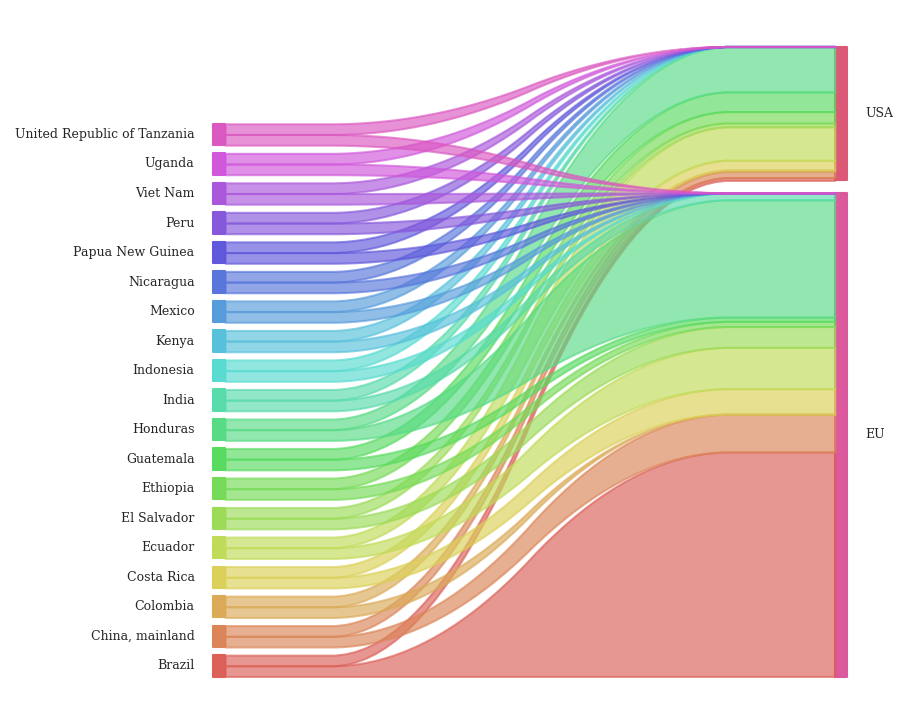

In [328]:
# Load saved Sankey diagram image file
from IPython.display import Image

Image(filename='coffee_2021.png')

### Draw multilevel Sankeys diagram using plotly library

Since there are many countries in the EU, a Sankey diagram of the imports of coffee beans by countries in the EU
* plotly libary (https://plotly.com/python/)
* refer to following link
    - Sankey Diagram in Python (https://plotly.com/python/sankey-diagram/)
    - How to Create a Sankey Diagram in Plotly Python? (https://lifewithdata.com/2022/08/29/how-to-create-a-sankey-diagram-in-plotly-python/)

In [18]:
print(grouped_df_EU)

     Reporter Country Code (M49)           Reporter Countries  \
0                             76                       Brazil   
1                             76                       Brazil   
2                             76                       Brazil   
3                             76                       Brazil   
4                             76                       Brazil   
..                           ...                          ...   
336                          834  United Republic of Tanzania   
337                          834  United Republic of Tanzania   
338                          834  United Republic of Tanzania   
339                          834  United Republic of Tanzania   
340                          834  United Republic of Tanzania   

     Partner Country Code (M49) Partner Countries      Value Countries Group  
0                            40           Austria      18.83              EU  
1                            56           Belgium  175590.57 

In [19]:
# Data processing for EU
grouped_df_EU_partner = grouped_df_EU.groupby(['Partner Countries', 'Countries Group'])['Value'].sum().reset_index()

In [20]:
print(grouped_df_EU_partner)

   Partner Countries Countries Group       Value
0            Austria              EU     2453.29
1            Belgium              EU   507123.94
2           Bulgaria              EU    12872.40
3            Croatia              EU    15389.78
4             Cyprus              EU      952.81
5            Czechia              EU      754.61
6            Denmark              EU     9355.81
7            Estonia              EU      822.02
8            Finland              EU    49852.55
9             France              EU   130290.73
10           Germany              EU  1020574.36
11            Greece              EU    51005.11
12           Hungary              EU      119.71
13           Ireland              EU     4029.31
14             Italy              EU   585005.96
15            Latvia              EU     4440.05
16         Lithuania              EU     2035.00
17        Luxembourg              EU       17.71
18             Malta              EU       53.94
19       Netherlands

In [21]:
selected_df_EU = selected_df_EU.loc[:, ['Reporter Countries', 'Countries Group', 'Value']]
selected_df_EU.columns = ['source', 'target', 'value']

In [22]:
grouped_df_EU_partner.columns = ['target', 'source', 'value']

In [23]:
print(selected_df_EU)

                         source target       value
0                        Brazil     EU  1049988.02
1               China, mainland     EU    13537.39
2                      Colombia     EU   176480.77
3                    Costa Rica     EU    28297.87
4                       Ecuador     EU      433.56
5                   El Salvador     EU     6818.77
6                      Ethiopia     EU   118729.75
7                     Guatemala     EU    45684.76
8                      Honduras     EU   193056.53
9                         India     EU   156386.90
10                    Indonesia     EU    97621.73
11                        Kenya     EU    17767.31
12                       Mexico     EU    23943.50
13                    Nicaragua     EU    53344.60
14             Papua New Guinea     EU    19911.64
15                         Peru     EU    91928.09
16                     Viet Nam     EU   548093.36
17                       Uganda     EU   212314.23
18  United Republic of Tanzania

In [24]:
# Data processing for USA
selected_df_US = selected_df_US.loc[:, ['Reporter Countries', 'Countries Group', 'Value']]
selected_df_US.columns = ['source', 'target', 'value']

In [25]:
print(selected_df_US)

                          source target      value
38                        Brazil    USA  445607.72
72               China, mainland    USA    3851.99
116                     Colombia    USA  284124.44
160                   Costa Rica    USA   28993.35
205                      Ecuador    USA     215.35
249                  El Salvador    USA   15601.23
280                     Ethiopia    USA   30934.90
324                    Guatemala    USA   90250.62
360                     Honduras    USA  110352.68
414                        India    USA    2906.95
449                    Indonesia    USA   57694.03
479                        Kenya    USA    5464.37
518                       Mexico    USA   62090.33
557                    Nicaragua    USA   67823.39
572             Papua New Guinea    USA    8957.75
615                         Peru    USA   42863.92
638                       Uganda    USA   22329.40
664  United Republic of Tanzania    USA    2410.09
700                     Viet Na

In [26]:
# make links for all nodes(EU + USA)
links = pd.concat([selected_df_EU, grouped_df_EU_partner, selected_df_US], axis=0)

In [27]:
print(links)

                          source target       value
0                         Brazil     EU  1049988.02
1                China, mainland     EU    13537.39
2                       Colombia     EU   176480.77
3                     Costa Rica     EU    28297.87
4                        Ecuador     EU      433.56
..                           ...    ...         ...
572             Papua New Guinea    USA     8957.75
615                         Peru    USA    42863.92
638                       Uganda    USA    22329.40
664  United Republic of Tanzania    USA     2410.09
700                     Viet Nam    USA   143255.49

[65 rows x 3 columns]


In [28]:
# make unique node (sources and targets)
unique_source_target = list(pd.unique(links[['source','target']].values.ravel('k')))

In [29]:
print(unique_source_target)

['Brazil', 'China, mainland', 'Colombia', 'Costa Rica', 'Ecuador', 'El Salvador', 'Ethiopia', 'Guatemala', 'Honduras', 'India', 'Indonesia', 'Kenya', 'Mexico', 'Nicaragua', 'Papua New Guinea', 'Peru', 'Viet Nam', 'Uganda', 'United Republic of Tanzania', 'EU', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'USA']


In [30]:
# mapping nodes
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}
mapping_dict

{'Brazil': 0,
 'China, mainland': 1,
 'Colombia': 2,
 'Costa Rica': 3,
 'Ecuador': 4,
 'El Salvador': 5,
 'Ethiopia': 6,
 'Guatemala': 7,
 'Honduras': 8,
 'India': 9,
 'Indonesia': 10,
 'Kenya': 11,
 'Mexico': 12,
 'Nicaragua': 13,
 'Papua New Guinea': 14,
 'Peru': 15,
 'Viet Nam': 16,
 'Uganda': 17,
 'United Republic of Tanzania': 18,
 'EU': 19,
 'Austria': 20,
 'Belgium': 21,
 'Bulgaria': 22,
 'Croatia': 23,
 'Cyprus': 24,
 'Czechia': 25,
 'Denmark': 26,
 'Estonia': 27,
 'Finland': 28,
 'France': 29,
 'Germany': 30,
 'Greece': 31,
 'Hungary': 32,
 'Ireland': 33,
 'Italy': 34,
 'Latvia': 35,
 'Lithuania': 36,
 'Luxembourg': 37,
 'Malta': 38,
 'Netherlands': 39,
 'Poland': 40,
 'Portugal': 41,
 'Romania': 42,
 'Slovakia': 43,
 'Slovenia': 44,
 'Spain': 45,
 'Sweden': 46,
 'USA': 47}

In [31]:
links['source'] = links['source'].map(mapping_dict)
links['target'] = links['target'].map(mapping_dict)

In [32]:
print(links)

     source  target       value
0         0      19  1049988.02
1         1      19    13537.39
2         2      19   176480.77
3         3      19    28297.87
4         4      19      433.56
..      ...     ...         ...
572      14      47     8957.75
615      15      47    42863.92
638      17      47    22329.40
664      18      47     2410.09
700      16      47   143255.49

[65 rows x 3 columns]


In [33]:
links_dict = links.to_dict(orient='list')

In [34]:
print(links_dict)

{'source': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 16], 'target': [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47], 'value': [1049988.02, 13537.39, 176480.77, 28297.87, 433.56, 6818.7699999999995, 118729.75, 45684.76, 193056.53, 156386.9, 97621.73, 17767.31, 23943.5, 53344.600000000006, 19911.64, 91928.09, 548093.36, 212314.22999999998, 33227.79, 2453.29, 507123.94, 12872.400000000001, 15389.779999999999, 952.8100000000001, 754.61, 9355.81, 822.02, 49852.55, 130290.73, 1020574.36, 51005.11, 119.71, 4029.31, 585005.96, 4440.05, 2035.0, 17.71, 53.94, 64259.270000000004, 33742.15, 28264.

In [35]:
# Load ploty libray to draw multilevel Sankey diagram
import plotly.graph_objects as go

In [36]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# define the Sankey diagram trace with custom node colors

In [37]:
# make colors for nodes
colorscale = [
    '#4575b4',  # blue
    '#91bfdb',
    '#e0f3f8',
    '#ffffbf',  # yellow
    '#fee090',
    '#fc8d59',  # red
    '#d73027',
]
colors = [colorscale[i % len(colorscale)] for i in range(76)]

In [38]:
# Draw multilevel Sankey diagram 
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label = unique_source_target,
        color = color_palette
    ),
    link = dict(
        source= links_dict['source'],
        target = links_dict['target'],
        value = links_dict['value'],
    )
)
])

In [64]:
fig.update_layout(title_text="Coffee bean shipments from major coffee bean producing countries and imports from USA & EU<br>Data base year: 2021", font_size=10)

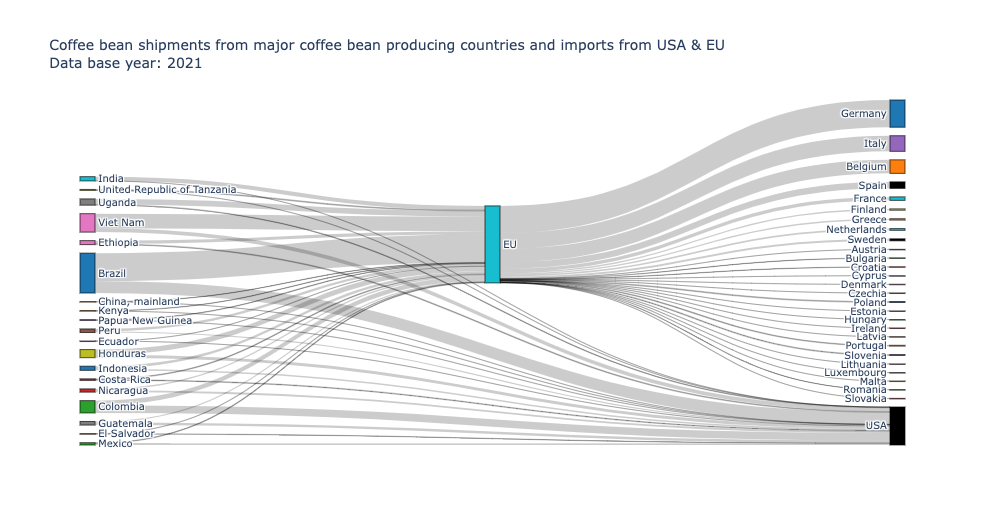

In [67]:
from IPython.display import Image
Image(filename='multilevel_sankey_coffeeGreen_2021.png')